In [1]:
#%%

import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import coint
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pykalman import KalmanFilter
import warnings
warnings.filterwarnings('ignore')

import itertools

from scipy.optimize import minimize

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Softmax, LSTM, Dropout

In [2]:
#%%

# Extract Price
symbols = ['GDX','GLD', 'AAPL','GOOGL', 'META','AMD',
           'NVDA','CSCO', 'ORCL', 'TTWO', 'EA', 'HYG', 
           'LQD', 'JNK', 'SLV', 'SIVR', 'USO', 'UWT', 
           'QQQ', 'SPY', 'VOO', 'VDE', 'VTI', 'EMLP', 'VDC', 
           'FSTA', 'KXI', 'IBB', 'VHT','VNQ', 'IYR', 'MSFT', 
           'PG', 'TMF', 'UPRO', 'WFC', 'JPM', 'GS', 'CVX', 
           'XOM', 'INTC', 'COST', 'WMT', 'T', 'VZ', 'CMCSA', 'AMZN']            

df = yf.download(symbols, start= '2013-01-01', end = '2023-12-31')              
price_df = df['Adj Close']
price_df.dropna(axis = 1, inplace = True)                                       

tickers = list(price_df.columns)                                                
num_stocks = price_df.shape[1]                                                 

# Split into Training & Testing set
split = int(price_df.shape[0] * 0.8)
price_df_training = price_df[:split]
price_df_testing = price_df[split:]
price_df_testing_60_window = price_df[split-60:]

[*********************100%***********************]  47 of 47 completed


In [3]:
# %%

# Find cointegrated stock pair
coint_pvalue_df = pd.DataFrame(index=tickers, columns=tickers)                                  
coint_pair = []                                                                                 

for i, ticker1 in enumerate(tickers):
    for j, ticker2 in enumerate(tickers):
        if i == j:
            continue
        p_value = coint(price_df_training.iloc[:, i],price_df_training.iloc[:, j])[1]
        coint_pvalue_df.loc[ticker1,ticker2] = p_value
        if i > j and p_value < 0.0015:
            coint_pair.append([ticker1, ticker2])

coint_pvalue_df = coint_pvalue_df.astype(float) 

In [ ]:
#%%
coint_pair

[['KXI', 'CMCSA'], ['ORCL', 'GOOGL'], ['UPRO', 'ORCL'], ['VDC', 'CMCSA']]

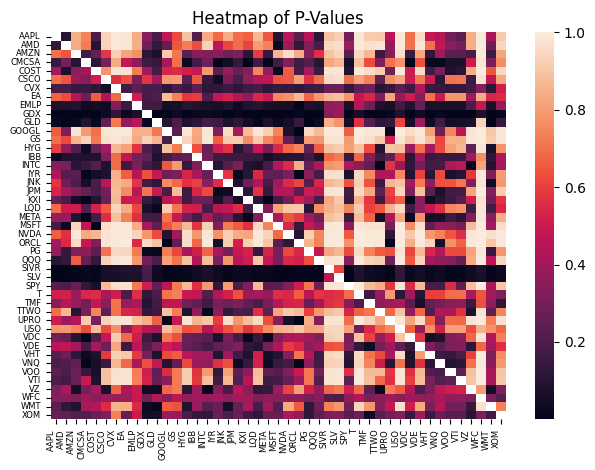

In [9]:
# %%
# Heatmap of coint_pvalue_df
sns.heatmap(coint_pvalue_df, xticklabels=tickers, yticklabels=tickers)
plt.title('Heatmap of P-Values')
plt.xticks(ha='right', size=6)
plt.yticks(size=6)
plt.tight_layout()
plt.show();

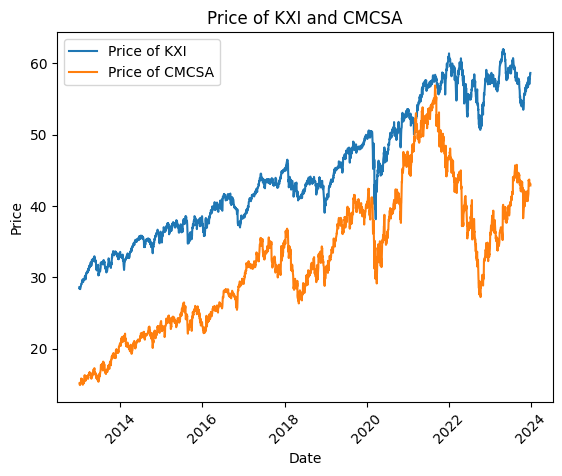

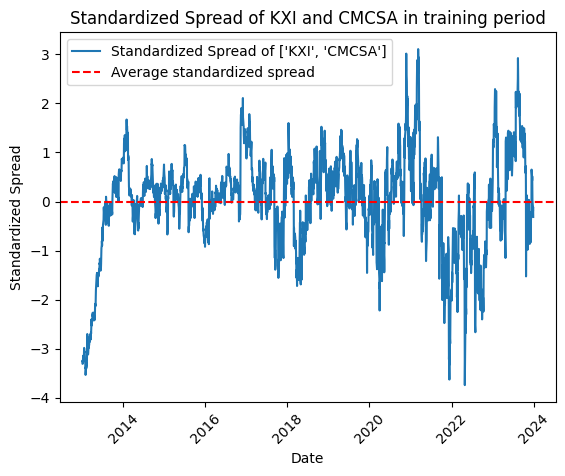

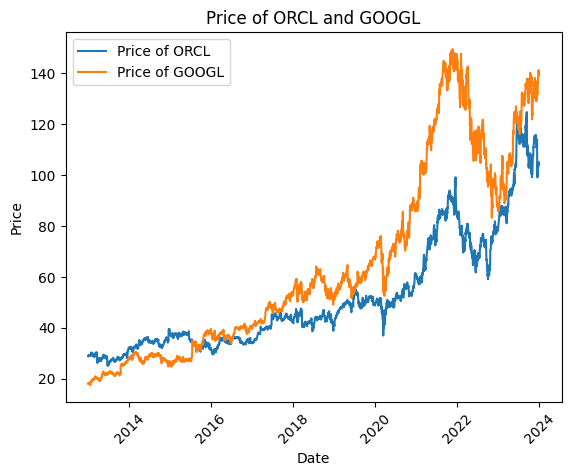

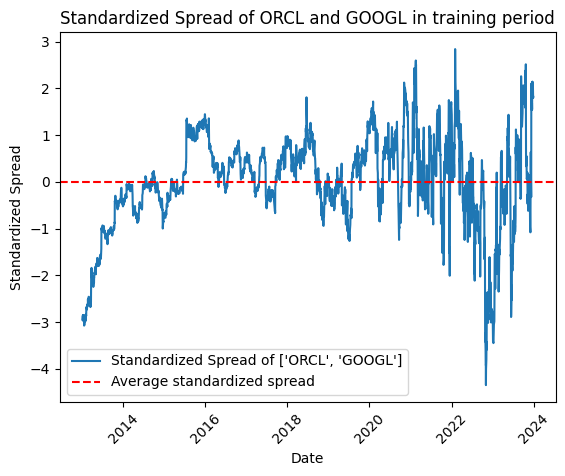

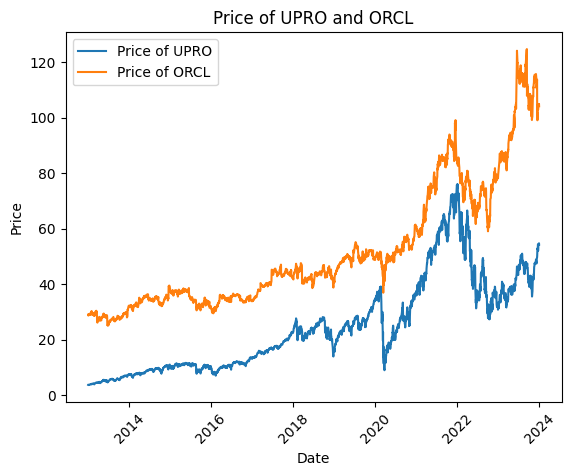

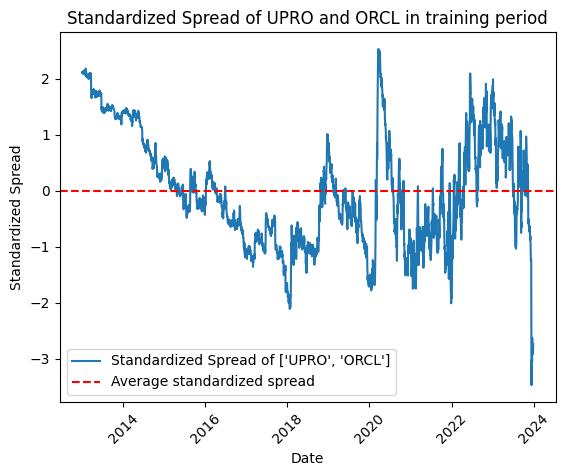

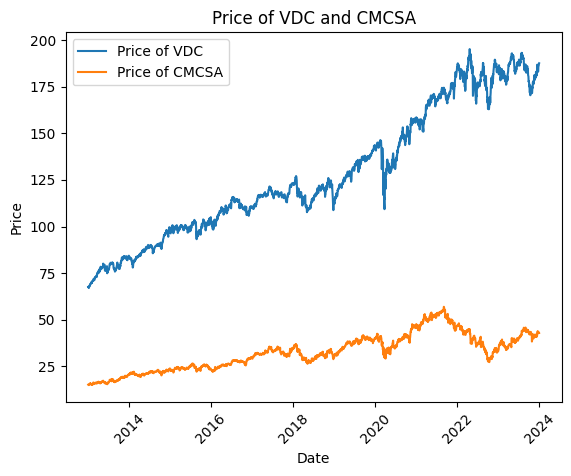

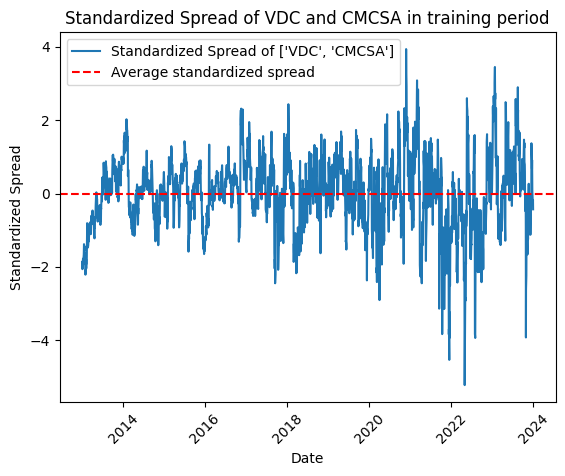

In [5]:
# %%

def KalmanFilterRegression(x,y):
    model1 = sm.OLS(y,x)
    result = model1.fit()
    obs_mat = np.vstack([x]).T[:, np.newaxis] 

    kf = KalmanFilter(
        initial_state_mean = result.params,
        initial_state_covariance = result.cov_params(),
        transition_matrices = 1,
        transition_offsets = 0,
        observation_matrices = obs_mat,
        observation_offsets = 0,
        observation_covariance = result.mse_model,
        n_dim_obs = 1,
        n_dim_state = 1
    )
    kf = kf.em(y, em_vars = ["transition_covariance"])
    state_means, state_covs = kf.filter(y)
    return state_means.flatten()

# Price & spread Plot
time_index = price_df.index
for j in range(len(coint_pair)):
    stock1 = price_df.loc[:, coint_pair[j][0]]
    stock2 = price_df.loc[:, coint_pair[j][1]]
    plt.figure()
    plt.plot(time_index, stock1, label=f"Price of {coint_pair[j][0]}")
    plt.plot(time_index, stock2, label=f"Price of {coint_pair[j][1]}")
    plt.title(f"Price of {coint_pair[j][0]} and {coint_pair[j][1]}")
    plt.xlabel("Date") 
    plt.xticks(fontsize=10, rotation=45)
    plt.ylabel("Price")
    plt.legend()
    
    
    b = KalmanFilterRegression(stock1, stock2)
    spread = stock2 - stock1 * b
    std_spread = (spread - spread.mean()) / spread.std()
    plt.figure()
    plt.plot(time_index, std_spread, label=f"Standardized Spread of {coint_pair[j]}")
    plt.title(f"Standardized Spread of {coint_pair[j][0]} and {coint_pair[j][1]} in training period")
    plt.xlabel("Date") 
    plt.xticks(fontsize=10, rotation=45)
    plt.ylabel("Standardized Spread")
    plt.axhline(y=std_spread.mean(), color='red', linestyle='--', label='Average standardized spread')
    plt.legend()

In [6]:
#%%

class PairTradingStrategy:

    def __init__(self, x, y, hedgeratio, long_entry_Zscore, long_exit_Zscore, short_entry_Zscore, short_exit_Zscore, weight, portfolio=1000000):
        self.x = x
        self.y = y
        self.hedgeratio = hedgeratio
        self.portfolio = portfolio
        self.weight = weight
        self.long_entry_Zscore = long_entry_Zscore
        self.long_exit_Zscore = long_exit_Zscore
        self.short_entry_Zscore = short_entry_Zscore
        self.short_exit_Zscore = short_exit_Zscore

        self.spread = self.y - self.hedgeratio * self.x
        self.rolling_spread_mean = self.spread.rolling(window=60).mean()
        self.rolling_spread_sd = self.spread.rolling(window=60).std()

        self.z_score = (self.spread - self.rolling_spread_mean) / self.rolling_spread_sd

        self.df = df

        self.position = np.zeros(len(self.z_score))
        self.cash = np.zeros(len(self.z_score))
        self.returns = np.zeros(len(self.z_score))
        self.cumulative_cash = np.zeros(len(self.z_score))

        self._generate_trading_signals() 

    def _generate_trading_signals(self):
        long_entry = (self.z_score.shift(1) > self.long_entry_Zscore) & (self.z_score < self.long_entry_Zscore)
        hold_long_entry = self.z_score < self.long_exit_Zscore
        long_exit = (self.z_score.shift(1) < self.long_exit_Zscore) & (self.z_score > self.long_exit_Zscore)

        short_entry = (self.z_score.shift(1) < self.short_entry_Zscore) & (self.z_score > self.short_entry_Zscore)
        hold_short_entry = self.z_score > self.short_exit_Zscore
        short_exit = (self.z_score.shift(1) > self.short_exit_Zscore) & (self.z_score < self.short_exit_Zscore)

        self.position[long_entry] = 1
        self.position[hold_long_entry] = 1
        self.position[short_entry] = -1
        self.position[hold_short_entry] = -1
        self.position[long_exit] = 0
        self.position[short_exit] = 0

    def calculate_returns(self):
        x_long_entry = y_long_entry = hedgeratio_long_entry = None
        x_short_entry = y_short_entry = hedgeratio_short_entry = None
        for i in range(1, len(self.z_score)):
            # Long entry
            if self.position[i] == 1 and self.position[i - 1] == 0:
                x_long_entry = self.x[i]
                y_long_entry = self.y[i]
                hedgeratio_long_entry =  self.hedgeratio[i]

            # Long exit & calculate cash
            if self.position[i] == 0 and self.position[i - 1] == 1 and x_long_entry is not None and y_long_entry is not None:
                x_long_exit = self.x[i]
                y_long_exit = self.y[i]
                self.cash[i] = - (self.portfolio * self.weight[i]) / (hedgeratio_long_entry * x_long_entry) * (x_long_exit - x_long_entry) + \
                                 (self.portfolio * self.weight[i]) / y_long_entry * (y_long_exit - y_long_entry)
                self.returns[i] = self.cash[i] / ((self.portfolio * self.weight[i]) / (hedgeratio_long_entry * x_long_entry) * x_long_exit + \
                                                  (self.portfolio * self.weight[i]) / y_long_entry * y_long_entry)

            # Short entry
            if self.position[i] == -1 and self.position[i - 1] == 0:
                x_short_entry = self.x[i]
                y_short_entry = self.y[i]
                hedgeratio_short_entry = self.hedgeratio[i]

            # Short exit & calculate cash
            if self.position[i] == 0 and self.position[i - 1] == -1 and x_short_entry is not None and y_short_entry is not None:
                x_short_exit = self.x[i]
                y_short_exit = self.y[i]
                self.cash[i] = (self.portfolio * self.weight[i]) / (hedgeratio_short_entry * x_short_entry) * (x_short_exit - x_short_entry) - \
                               (self.portfolio * self.weight[i]) / y_short_entry * (y_short_exit - y_short_entry)
                self.returns[i] = self.cash[i] / ((self.portfolio * self.weight[i]) / (hedgeratio_short_entry * x_short_entry) * x_short_entry + \
                                                  (self.portfolio * self.weight[i]) / y_short_entry * y_short_exit)

        self.cumulative_cash = np.cumsum(self.cash)

    def calculate_sharpe_ratio(self, rfr=0.0):
        annualized_return = np.mean(self.returns)
        annualized_std = np.std(self.returns) * np.sqrt(252)
        sharpe_ratio = (annualized_return - rfr) / annualized_std
        return sharpe_ratio

In [7]:
# %%

# 1. Optimal Zscore
param_grid = {
    'longentryZscore': np.linspace(-3, 0, num=16),
    'longexitZscore': np.linspace(-3, 0, num=16),
    'shortentryZscore': np.linspace(0, 3, num=16),
    'shortexitZscore': np.linspace(0, 3, num=16)
}
param_combinations = list(itertools.product(param_grid['longentryZscore'], param_grid['longexitZscore'], param_grid['shortentryZscore'], param_grid['shortexitZscore']))


best_Z_score = [None] * len(coint_pair)

equal_weight = [1/len(coint_pair) for i in range(len(price_df_training))]

#return_matrix = np.zeros((price_df_training.shape[0], len(coint_pair)))

for j in range(len(coint_pair)):
    x = price_df_training.loc[:, coint_pair[j][0]]
    y = price_df_training.loc[:, coint_pair[j][1]]
    hedgeratio = KalmanFilterRegression(x, y)

    best_cumulative_cash = -np.inf
    best_params = None
    
    for longentryZscore, longexitZscore, shortentryZscore, shortexitZscore in param_combinations:

        if longentryZscore < longexitZscore and shortentryZscore > shortexitZscore: 

            optim_pair_strategy = PairTradingStrategy(x, y, hedgeratio, 
                                                      long_entry_Zscore=longentryZscore, 
                                                      long_exit_Zscore=longexitZscore, 
                                                      short_entry_Zscore=shortentryZscore, 
                                                      short_exit_Zscore=shortexitZscore, 
                                                      weight=equal_weight)

            optim_pair_strategy.calculate_returns()

            final_cumulative_cash = optim_pair_strategy.cumulative_cash[-1]

            long_entry = (optim_pair_strategy.z_score.shift(1) > optim_pair_strategy.long_entry_Zscore) & (optim_pair_strategy.z_score < optim_pair_strategy.long_entry_Zscore)
            long_entry_trade = long_entry.sum()
            short_entry = (optim_pair_strategy.z_score.shift(1) < optim_pair_strategy.short_entry_Zscore) & (optim_pair_strategy.z_score > optim_pair_strategy.short_entry_Zscore)
            short_entry_trade = short_entry.sum()   

            # Find optimal z_score in this for loop
            if final_cumulative_cash > best_cumulative_cash and long_entry_trade >= 20 and short_entry_trade >= 20:
                best_cumulative_cash = final_cumulative_cash         
                best_params = {'long_entry_Zscore': longentryZscore, 'long_exit_Zscore': longexitZscore, 'short_entry_Zscore': shortentryZscore, 'short_exit_Zscore': shortexitZscore}
                best_Z_score[j] = best_params


best_Z_score

[{'long_entry_Zscore': -2.4,
  'long_exit_Zscore': -0.3999999999999999,
  'short_entry_Zscore': 0.4,
  'short_exit_Zscore': 0.2},
 {'long_entry_Zscore': -2.4,
  'long_exit_Zscore': 0.0,
  'short_entry_Zscore': 1.4000000000000001,
  'short_exit_Zscore': 1.2000000000000002},
 {'long_entry_Zscore': -2.4,
  'long_exit_Zscore': -1.0,
  'short_entry_Zscore': 0.6000000000000001,
  'short_exit_Zscore': 0.4},
 {'long_entry_Zscore': -2.2,
  'long_exit_Zscore': -0.19999999999999973,
  'short_entry_Zscore': 0.2,
  'short_exit_Zscore': 0.0}]

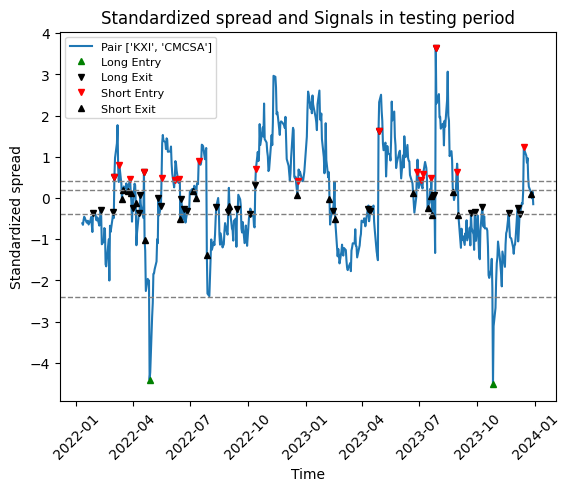

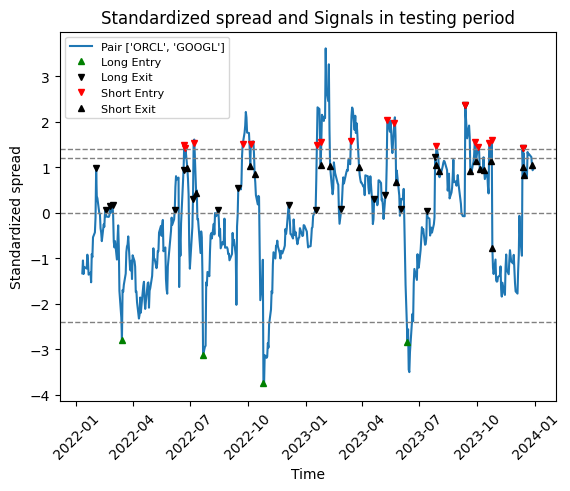

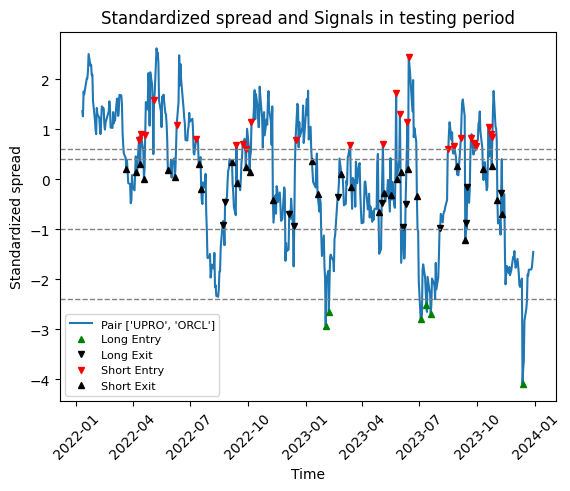

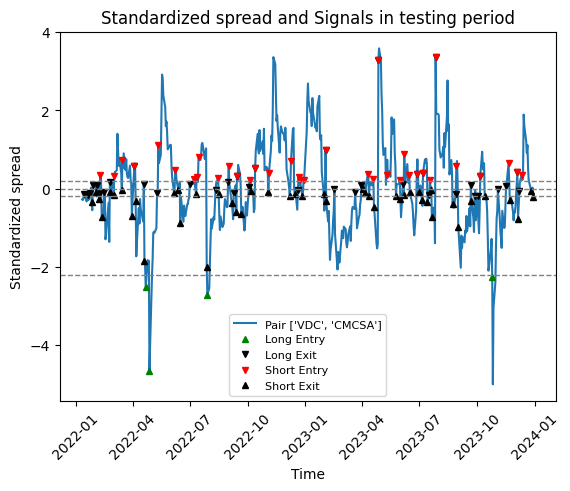

In [8]:
# Plot Spread and Signals

equal_weight = [1/len(coint_pair) for i in range(len(price_df_testing))]

for j in range(len(coint_pair)):
    x = price_df_testing.loc[:, coint_pair[j][0]]
    y = price_df_testing.loc[:, coint_pair[j][1]]
    hedgeratio = KalmanFilterRegression(x, y)

    ew_strategy = PairTradingStrategy(x, y, hedgeratio, 
                                      long_entry_Zscore=best_Z_score[j]['long_entry_Zscore'], 
                                      long_exit_Zscore=best_Z_score[j]['long_exit_Zscore'], 
                                      short_entry_Zscore=best_Z_score[j]['short_entry_Zscore'], 
                                      short_exit_Zscore=best_Z_score[j]['short_exit_Zscore'], 
                                      weight=equal_weight
                                      )
        
    ew_strategy.calculate_returns()   
    ew_sharpe_ratio = ew_strategy.calculate_sharpe_ratio()

    # Standardized spread and signals of each pair over time
    plt.figure()
    time_index = price_df_testing.index
    plt.plot(time_index, ew_strategy.z_score, label=f"Pair {coint_pair[j]}")

    # Plot all signals 
    long_entry = (ew_strategy.z_score.shift(1) > ew_strategy.long_entry_Zscore) & (ew_strategy.z_score < ew_strategy.long_entry_Zscore)
    long_exit = (ew_strategy.z_score.shift(1) < ew_strategy.long_exit_Zscore) & (ew_strategy.z_score > ew_strategy.long_exit_Zscore)
    short_entry = (ew_strategy.z_score.shift(1) < ew_strategy.short_entry_Zscore) & (ew_strategy.z_score > ew_strategy.short_entry_Zscore)
    short_exit = (ew_strategy.z_score.shift(1) > ew_strategy.short_exit_Zscore) & (ew_strategy.z_score < ew_strategy.short_exit_Zscore)
    plt.plot(time_index[long_entry], ew_strategy.z_score[long_entry], '^', color='g', label='Long Entry', markersize=4)
    plt.plot(time_index[long_exit], ew_strategy.z_score[long_exit], 'v', color='k', label='Long Exit', markersize=4)
    plt.plot(time_index[short_entry], ew_strategy.z_score[short_entry], 'v', color='r', label='Short Entry', markersize=4)
    plt.plot(time_index[short_exit], ew_strategy.z_score[short_exit], '^', color='k', label='Short Exit', markersize=4)
    # Add horizontal lines for entry and exit z-scores
    plt.axhline(y=ew_strategy.long_entry_Zscore, color='gray', linestyle='--', lw=1)
    plt.axhline(y=ew_strategy.long_exit_Zscore, color='gray', linestyle='--', lw=1)
    plt.axhline(y=ew_strategy.short_entry_Zscore, color='gray', linestyle='--', lw=1)
    plt.axhline(y=ew_strategy.short_exit_Zscore, color='gray', linestyle='--', lw=1)
    plt.xticks(fontsize=10, rotation=45)
    plt.title('Standardized spread and Signals in testing period')
    plt.xlabel('Time')
    plt.ylabel('Standardized spread')
    plt.legend(fontsize=8, loc='best')


